# Logistic Regression

Today we will start working on our second Machine Learning model: Logistic Regression.

# Table of contents
[1. Logistic Regression](#1.-Linear-Regression)
- [1.1 Using logistic regression for child's low birth weight using father's engagement as predictor](#1.1-Using-logistic-regression-for-child's-low-birth-weight-using-father's-engagement-as-predictor)
- [1.2 Plotting the data](#1.2-Plotting-the-data)
- [1.3 Splitting data into train and test sets](#1.3-Splitting-data-into-train-and-test-sets)
- [1.4 Running the logistic regression algorithm](#1.4-Running-the-logistic-regression-algorithm)
- [1.5 Evaluating the logistic regression model](#1.5-Evaluating-the-logistic-regression-model)


[2. Multiple Logistic Regression](#2.-Multiple-Linear-Regression)
- [2.1 Multiple logistic regression for income in Year 1 using various features on father's engagement as predictors](#2.1-Multiple-linear-regression-for-income-in Year-1-using-mother's-and-father's-ages-at-the-time-of-birth-as-predictor)
- [2.2 Plotting the data](#2.2-Plotting-the-data)
- [2.3 Splitting data into train and test sets](#2.3-Splitting-data-into-train-and-test-sets)
- [2.4 Running the multiple logistic regression algorithm](#2.4-Running-the-multiple-logistic-regression-algorithm)
- [2.5 Evaluation and generalization](#2.5-Evaluation-and-generalization)



# 1. Logistic Regression

Logistic regression models the relationship between a binary outcome $Y$ that can be either 1 or 0 and a predictor $X$. The main difference between logistic regression and linear and multiple linear regression is that the resulting model is not linear (it is not a line but a curve) and that it does not predict the value of the outcome $Y$ but instead it predicts the probability that $Y$ is equal to 1.

As in linear regression, we plot the data on a scatter plot and then compute the best-fit curve through the data points using the following equation which takes into account that $Y$ is a binary variable:

$$ \frac{p(Y)}{1-p(Y)} = c_0 + c_1 X + \epsilon$$

where $p(Y)$ is the probability that $Y=1, $$c_0$ is the regression coefficient associated with the probability that $Y=1$ when $X=0$, and $c_1$ is the regression coefficient that tells us how much the probability that $Y=1$ changes when the predictor $X$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit curve provides a nonlinear model which allows us to make predictions about the probability that $Y=1$ or $Y=0$ given the value of $X$.

In this section we will build a logistic regression model to predict layoff. For the predictor $X$, we will use information about whether the mother had "done regular work for pay last week" in wave 5 (when the child was ~9 years old) (feature m5i4).

In [1]:
# First, we load the libraries we will need for this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
import sklearn # this library provides functions for performing machine learning on data
import ff_functions as fff # this is the library we are providing for you to perform common operations on data

In [2]:
# We read in the Fragile Families data as in previous notebooks
background = "../../ai4all_data/background.csv"
data_frame = pd.read_csv(background, low_memory=False)
# We set the index of the DataFrame to match the challengeID
data_frame = data_frame.set_index('challengeID')

# 1.1 Using logistic regression for child's low birth weight using father's engagement as predictor

In this section we will build a logistic regression model to predict child's low birth weight. As a predictor, we will use an engineered feature, which we constructed on day 3, following a paper published in March 2018: "Father Early Engagement Behaviors and Infant Low Birth Weight" by Lee et al.

The paper combined the following three features into a single "father involvement" variable.

* "f1b16": During the baby mother's preg, did you give her money or buy things for the baby/ies?
* "f1b17": Did you help in other ways, like providing transportation / doing chores?
* "f1a2": Were you present at the birth?

They then used the engineered feature to predict the following **binary** variable:
* "cm1lbw": Constructed variable - Low Birth Weight


### Discuss with your partner:
TODO: fill in

### Subselecting variables

In [8]:
# Pick mother's age (cm1age), father's age (cf1age), and father reported income (f211)
baby_weight = fff.pick_ff_variables(data_frame, ["f1b16", "f1b17", "f1a2", "cm1lbw"], 
                                   remove_nans=True, remove_negatives=True)

# Let's change the names of the columns so it's easier for us to work with the data
baby_weight.columns = ["gave_money", "other_help", "present_at_birth", "low_birth_weight"]

baby_weight.head()

Data frame with  2267  rows and  4 columns.


,gave_money,other_help,present_at_birth,low_birth_weight
challengeID,,,,
2,1,1,2,0
4,1,1,1,0
5,1,2,2,0
7,1,1,1,0
8,1,1,1,0


In [9]:
baby_weight.describe()

,gave_money,other_help,present_at_birth,low_birth_weight
count,2267.000000,2267.000000,2267.000000,2267.000000
mean,1.079400,1.097045,1.276136,0.114248
std,0.270422,0.296084,0.447183,0.318182
min,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,2.000000,0.000000
max,2.000000,2.000000,2.000000,1.000000


### TODO: make this into a problem

In [10]:
### Generating an engineered feature:
baby_weight["father_engagement"] = (baby_weight.gave_money + \
                                    baby_weight.other_help + \
                                    baby_weight.present_at_birth)/3
baby_weight.head()

,gave_money,other_help,present_at_birth,low_birth_weight,father_engagement
challengeID,,,,,
2,1,1,2,0,1.333333
4,1,1,1,0,1.000000
5,1,2,2,0,1.666667
7,1,1,1,0,1.000000
8,1,1,1,0,1.000000


### Discuss with your partner:
* Why would the combination of the three features be a better predictor than using the father's providing money only? What other weighings of the three variables would you consider and why?

### Answer:

# 1.2 Plotting the data
Let's plot the data using the scatterplot function we learned.

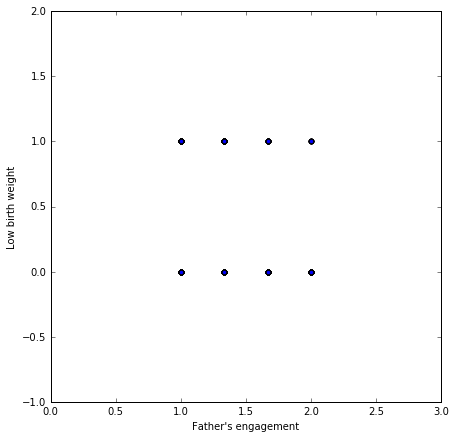

In [6]:
fff.scatterplot(baby_weight.father_engagement, \
                baby_weight.low_birth_weight, \
                xlabel = "Father's engagement", \
                ylabel = "Low birth weight")

TODO: discuss what it means. The students should notice that there are many points overlapping each other.

# 1.3 Splitting data into train and test sets

In [12]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split

X = baby_weight.father_engagement # predictor
y = baby_weight.low_birth_weight # outcome 
# The following line of code randomly splits both the outcome data and the predictor data into 
# a training and a testing set. The test_size argument is a number between 0 and 1 that tells the 
# function the percentage of data that should go into the test set.
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=100)

print(baby_weight.shape)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(2267, 5)
(1586,)
(681,)
(1586,)
(681,)


### Convert the sets to numpy arrays

In [14]:
numpy_train_X = fff.pandas_to_2d_numpy(train_X)
numpy_train_y = fff.pandas_to_2d_numpy(train_y)

numpy_test_X = fff.pandas_to_2d_numpy(test_X)
numpy_test_y = fff.pandas_to_2d_numpy(test_y)

# 1.4 Running the logistic regression algorithm
**Let's do linear regression with `sklearn.linear_model.LogisticRegression`** You can learn about this function at 
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [18]:
from sklearn import linear_model

# intialize the model
log_reg = linear_model.LogisticRegression()

# fit the model ON THE TRAINING DATA
log_reg.fit(numpy_train_X, numpy_train_y)

# read the resulting model's slope and intercept values
slope = log_reg.coef_[0][0]
intercept = log_reg.intercept_[0]

# print the linear regression model coefficients
print('slope = {}'.format(slope))
print('y-intercept = {}'.format(intercept))

slope = 0.7590864384726821
y-intercept = -2.924983162834194


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Plot the result

In [26]:
def scatterplot_with_curve(xdata, ydata, model, reg, xlabel="", ylabel="", title=""):
    fig = plt.figure(figsize=(7,5))
    plt.scatter(xdata, ydata)
    x = np.linspace(min(xdata)-5,max(xdata)+5, 100)
    loss = model(x * reg.coef_ + reg.intercept_)
    plt.plot(x, loss.ravel(), color='red', linewidth=3)
    plt.xlim(min(xdata)-5,max(xdata)+5)
    plt.ylim(min(ydata)-5,max(ydata)+5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

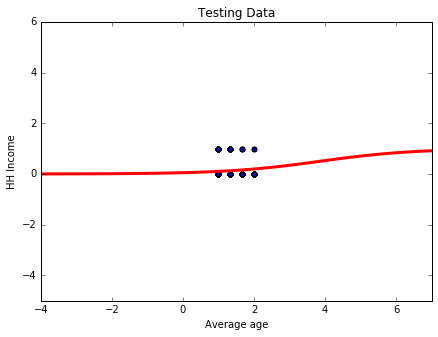

In [27]:
def model(x):
    return 1 / (1 + np.exp(-x))

#loss = model(linspace * reg.coef_ + reg.intercept_)
# Let's visualize how our model fits the testing data
scatterplot_with_curve(test_X, test_y, model, log_reg,
                          xlabel = "Average age", ylabel = "HH Income",\
                          title="Testing Data")

# 1.5 Evaluating the logistic regression model
We will use the $R^2$ score to quantify the performance of our model. Note that we always test the performance of the model using the testing data set (not the training data set).

TODO: the difference isn't zero below!!

In [34]:
# First we use our model to predict the testing data. That is, we pass the average age of parents in the 
# testing set (x_test) and predict household income (y_pred).
pred_y = log_reg.predict(numpy_test_X)
# Note that we used the sklearn function predict. This function is simply using our model y = m*x + b and
# applying it to the test data:
pred_y2 = model(numpy_test_X * log_reg.coef_ + log_reg.intercept_)
print('Difference between predictions: {}'.format(sum(pred_y-pred_y2)) )

Now, we can quantify how good our model is at predicting new values by computing R2 score


In [38]:
R2 = sklearn.metrics.r2_score(numpy_test_y, pred_y)
print('mean root of square error : {}'.format(R2))

mean root of square error : -0.13122923588039836


TODO: explain what this means (negative value?)

Let's compare this to the algorithm's performance on the training data:

In [39]:
pred_train_y = log_reg.predict(numpy_train_X)
R2 = sklearn.metrics.r2_score(numpy_train_y, pred_train_y)
print('mean root of square error : {}'.format(R2))

mean root of square error : -0.12802275960170695


TODO: comment on this.

## Multiple Logistic Regression

Multiple logistic regression models is the generalization of logistic regression to multiple predictors. That is, multiple logistic regression models the relationship between a binary outcome $Y$ that can be either 1 or 0 and multiple predictors $X_i$. 

The model is given by the equation

$$ \frac{p(Y)}{1-p(Y)} = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \dots + c_n X_n + \epsilon$$

where $p(Y)$ is the probability that $Y=1, $$c_0$ is the regression coefficient associated with the probability that $Y=1$ when $X_i=0$ for all $i$, and $c_i$ is the regression coefficient that tells us how much the probability that $Y=1$ changes when the predictor $X_i$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit curve provides a nonlinear model which allows us to make predictions about the probability that $Y=1$ or $Y=0$ given the values of $X_i$.

In this section we will build a multiple logistic regression model to predict eviction. For the predictor $X$ predictor, we will use SOMETHING (feature XXXXXXX) and SOMETHING2 (feature XXXX2).

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# subselect the column we are interested in
features = data_frame[['m5i4','m5f23d','f5i4','f5f23d']]
features['m5i4'] = features.m5i4.astype(str)
features['m5f23d'] = features.m5i4.astype(str)
features['f5i4'] = features.m5i4.astype(str)
features['f5f23d'] = features.m5i4.astype(str)
X = pd.get_dummies(features)

In [ ]:
X = X.loc[eviction.index]
#make sure the the number of rows are the same
print(X.shape)
print(eviction.shape)
# Split our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, eviction, test_size = 0.3, random_state = 100)